In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2024-10-27 18:52:09.109741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730065929.151958  141203 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730065929.166301  141203 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 18:52:09.315957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import yfinance as yf
import datetime as dt

# Load dataset
company = 'PETR4.SA'
start = dt.datetime(2014, 1, 1)
end = dt.datetime(2024, 1, 1)

data = yf.download(company, start=start, end=end)

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                     Adj Close      Close       High        Low  \
Ticker                     PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA   
Date                                                                   
2014-01-02 00:00:00+00:00  5.042312  16.750000  17.200001  16.650000   
2014-01-03 00:00:00+00:00  4.967053  16.500000  16.780001  16.410000   
2014-01-06 00:00:00+00:00  5.003179  16.620001  16.639999  16.160000   
2014-01-07 00:00:00+00:00  4.864704  16.160000  16.830000  16.120001   
2014-01-08 00:00:00+00:00  4.873733  16.190001  16.389999  16.139999   

Price                           Open    Volume  
Ticker                      PETR4.SA  PETR4.SA  
Date                                            
2014-01-02 00:00:00+00:00  17.150000  17284800  
2014-01-03 00:00:00+00:00  16.740000  17837600  
2014-01-06 00:00:00+00:00  16.450001  20526500  
2014-01-07 00:00:00+00:00  16.650000  19052500  
2014-01-08 00:00:00+00:00  16.270000  15874600  


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2484 entries, 2014-01-02 00:00:00+00:00 to 2023-12-28 00:00:00+00:00
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, PETR4.SA)  2484 non-null   float64
 1   (Close, PETR4.SA)      2484 non-null   float64
 2   (High, PETR4.SA)       2484 non-null   float64
 3   (Low, PETR4.SA)        2484 non-null   float64
 4   (Open, PETR4.SA)       2484 non-null   float64
 5   (Volume, PETR4.SA)     2484 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 135.8 KB


In [7]:
df = data["Close"]

In [8]:
df["Date"] = df.index

/tmp/ipykernel_141203/4039402861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df.index


In [9]:
df = df.reset_index(drop=True)

In [10]:
df.head()

Ticker,PETR4.SA,Date
0,16.750000,2014-01-02 00:00:00+00:00
1,16.500000,2014-01-03 00:00:00+00:00
2,16.620001,2014-01-06 00:00:00+00:00
3,16.160000,2014-01-07 00:00:00+00:00
4,16.190001,2014-01-08 00:00:00+00:00


In [11]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Normalize the Price column
scaler = MinMaxScaler()
df["PETR4.SA"] = scaler.fit_transform(df["PETR4.SA"].values.reshape(-1, 1))

In [12]:
df.head()

Ticker,PETR4.SA,Date
0,0.365676,2014-01-02 00:00:00+00:00
1,0.358392,2014-01-03 00:00:00+00:00
2,0.361888,2014-01-06 00:00:00+00:00
3,0.348485,2014-01-07 00:00:00+00:00
4,0.349359,2014-01-08 00:00:00+00:00


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the dataset
# n_steps is the number of previous days' prices to consider for prediction
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data) - 1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 10  # Number of time steps to consider for prediction

# Prepare the training data
data = df["PETR4.SA"].values
X, y = prepare_data(data, n_steps)

In [15]:
# Split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Reshape the input data for LSTM
X_train = X_train.reshape(-1, n_steps, 1)
X_test = X_test.reshape(-1, n_steps, 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

2024-10-27 18:53:03.547303: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/raiane/Documentos/Projetos/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1092
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2659e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4255e-04 
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3353e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1727e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1311e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6184e-04
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.0726e-04
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2479e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3355e-04
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1807e-04
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.3414e-04
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7587e-04
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2555e-04
Epo

In [30]:
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


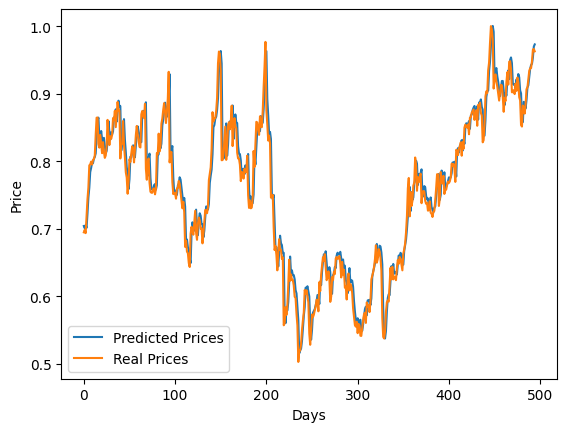

In [31]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(y_pred, label="Predicted Prices")
plt.plot(y_test, label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [25]:
# Predict using the trained model
future_steps = 10  # Number of days to predict
future_data = data[-n_steps:].reshape(-1, n_steps, 1)
predicted_prices = []

for i in range(future_steps):
    prediction = model.predict(future_data)[0, 0]
    predicted_prices.append(prediction)
    future_data = np.roll(future_data, -1, axis=1)
    future_data[0, -1] = prediction

# Inverse transform the predicted prices to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


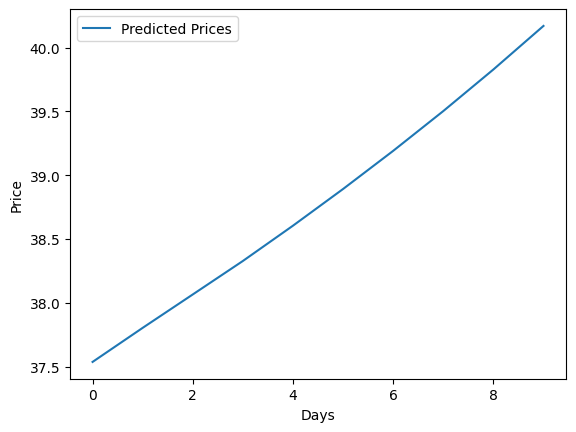

In [26]:
import matplotlib.pyplot as plt

# Plot the predicted prices
plt.plot(predicted_prices, label="Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()